In [53]:
%pwd
import sys
print(sys.executable)
%pip install seaborn
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
%pip install einops
%pip install torchsummary
%pip install scikit-learn

import math



/share/hackathon-env/bin/python3.10
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: /share/hackathon-env/bin/python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu121

[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: /share/hackathon-env/bin/python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: /share/hackathon-env/bin/python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to use

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib
from plot import create_plots
%pwd

'/home/trainee27'

In [ ]:
"""
This tweaked TTS-GAN architecture builds on a transformer‐based GAN design and augments it with a conditional autoencoder (with VAE properties) to 
anonymize long time series data. The overall idea is to first embed real signals into a latent space using an encoder, cluster these latent representations 
to capture similar patterns, and then use the averaged, cluster‐derived latent conditions to drive a conditional generator. The generator ultimately synthesizes 
realistic, anonymized signals that capture the key temporal dynamics of the original data without revealing individual identities.


The goal is to anonymize long time-series data (originally of dimension 8760×1, later reduced to 2190×1) using a conditional generative model. By combining a 
VAE‐like encoder, which learns latent embeddings with sampling capabilities, and a transformer-based GAN, the system learns to generate synthetic signals 
conditioned on cluster‐averaged characteristics. This ensures that while the generated data preserves statistical and temporal properties of the original 
signals, it removes sensitive identity-specific details



"""

In [3]:
df = pd.read_csv('smart_meters_london_2013.csv',parse_dates=['timestamp'])
df.set_index('timestamp', inplace=True)

In [7]:
!nvidia-smi


Sun Feb 23 08:18:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:81:00.0 Off |                    0 |
| N/A   29C    P0             63W /  500W |       1MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [7]:
# Add the tts-gan repository folder to the Python path
import sys
sys.path.append('/home/trainee27/tts-gan')



import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np

from GANModels import Generator, Discriminator, Encoder
from torch.utils.data import Dataset, DataLoader

In [8]:
# df -> dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, df):
        # The DataFrame "df" has the timestamps as index and each column as one sample.
        # Convert the DataFrame values and then transpose so that each row is one sample.
        self.data = df.values.T  # Shape becomes: (num_samples, sequence_length)
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        # Reshape the sample to (channels, height, width)
        sample = sample.reshape(1, 1, -1)
        return torch.tensor(sample, dtype=torch.float32)

In [9]:
# restrucure DF 

df_downsampled = df.iloc[::4, :]
data_tensor = TimeSeriesDataset(df_downsampled)

# We'll use only the first 100 samples for this test run 
#subset_dataset = Subset(data_tensor, indices=range(100))

loader = DataLoader(data_tensor, batch_size=32, shuffle=True)



In [11]:
# 3. Instantiate your GAN components
gen = Generator(seq_len=2190, channels=1, latent_dim=1000, patch_size=2)
# Create a discriminator that processes the time series
disc = Discriminator(in_channels=1, patch_size=2, emb_size=50, seq_length=2190, depth=3, n_classes=1)

# Optionally move models to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen.to(device)
disc.to(device)

# -------------------------------------------------------------------
# 4. Define optimizers and loss
optimizer_G = optim.Adam(gen.parameters(), lr=0.00022)
optimizer_D = optim.Adam(disc.parameters(), lr=0.0002)
criterion = nn.MSELoss()  # Using MSELoss for LSGAN loss

In [22]:
import torch
import torch.optim as optim
import torch.nn as nn
from GANModels import Generator, Discriminator, Encoder  # Make sure these classes have the new arguments


gen = Generator(seq_len=2190, 
                channels=1, 
                latent_dim=1000, 
                cond_dim=1000,   
                patch_size=2,
                embed_dim=10,    
                depth=3,
                num_heads=5,
                forward_drop_rate=0.5,
                attn_drop_rate=0.5,
                multi_scale=True,
                scale_small_factor=4,
                scale_med_factor=2, 
                res_weight_small=0.1,
                res_weight_med=0.2)

disc = Discriminator(in_channels=1, 
                     patch_size=2, 
                     emb_size=50, 
                     seq_length=2190, 
                     depth=3, 
                     n_classes=1,
                     multi_scale=True,
                     gp_weight=10.0)

enc = Encoder(in_channels=1, 
              patch_size=2, 
              emb_size=64, 
              seq_length=2190,
              depth=8, 
              num_heads=4, 
              latent_dim=1000, 
              drop_p=0.1, 
              forward_drop_p=0.1)

# Optionally move models to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen.to(device)
disc.to(device)
enc.to(device)

# ------------------------------------------------------
# 2. Define optimizers and loss function
# ------------------------------------------------------
optimizer_G = optim.Adam(gen.parameters(), lr=0.00022)
optimizer_D = optim.Adam(disc.parameters(), lr=0.0001)
optimizer_E = optim.Adam(enc.parameters(), lr=0.00025)
criterion = nn.MSELoss()  # Using MSELoss for LSGAN loss

In [23]:
for epoch in range(num_epochs):
    print("Epoch", epoch+1)
    for real_data in loader:
        real_data = real_data.to(device)
        batch_size = real_data.size(0)

        # Create labels for LSGAN (valid = 1, fake = 0)
        valid = torch.ones(batch_size, 1, device=device)
        fake  = torch.zeros(batch_size, 1, device=device)

        # ---------------------
        #  Compute Conditioning using Encoder on Real Data
        # ---------------------
        # Use the encoder on real data to get the condition vector.
        # If your Encoder returns multiple outputs (latent, mu, logvar), use only the latent.
        latent_cond, _, _ = enc(real_data)
        # Detach the condition so that it doesn't propagate gradients twice.
        latent_cond_target = latent_cond.detach()

        # ---------------------
        #  Train Generator
        # ---------------------
        optimizer_G.zero_grad()
        # Sample random noise as generator input
        z = torch.randn(batch_size, 1000, device=device)
        # Generate fake data using the noise and the condition from real data
        generated_data = gen(z, latent_cond)
        # The generator is encouraged to fool the discriminator:
        g_loss = criterion(disc(generated_data), valid)
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        real_loss = criterion(disc(real_data), valid)
        fake_loss = criterion(disc(generated_data.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)
        d_loss.backward()
        optimizer_D.step()

        # ---------------------
        #  Train Encoder
        # ---------------------
        # Encourage the encoder (when processing generated data) to recover the condition
        optimizer_E.zero_grad()
        latent_recon, _, _ = enc(generated_data.detach())
        # Use the detached condition vector as the target to avoid backward through the same graph twice
        enc_loss = criterion(latent_recon, latent_cond_target)
        enc_loss.backward()
        optimizer_E.step()

    print(f"Epoch {epoch+1}/{num_epochs} -- d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, enc_loss: {enc_loss.item():.4f}")

    # ---------------------
    #  Save Models Every 15 Epochs
    # ---------------------
    if (epoch + 1) % 15 == 0:
        torch.save(gen.state_dict(), f"generator_epoch_{epoch+1}_dL_{d_loss.item():.4f}_gL_{g_loss.item():.4f}.pth")
        torch.save(disc.state_dict(), f"discriminator_epoch_{epoch+1}_dL_{d_loss.item():.4f}_gL_{g_loss.item():.4f}.pth")
        torch.save(enc.state_dict(), f"encoder_epoch_{epoch+1}_encL_{enc_loss.item():.4f}.pth")
        print(f"Models saved at epoch {epoch+1}")

Epoch 1
Epoch 17/100 -- d_loss: 0.2468, g_loss: 0.3305, enc_loss: 0.0128
Epoch 18


KeyboardInterrupt: 

In [24]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

In [18]:
print("HI")

HI


In [25]:
def create_embeddings(encoder, dataset, batch_size=32, device=torch.device("cuda")):
    """
    Given an encoder and a dataset of original time series data,
    compute and return the latent embeddings (for a full run or subsample).
    """
    encoder.eval()
    # Wrap dataset into a DataLoader in case it's not already one.
    if not isinstance(dataset, DataLoader):
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    else:
        loader = dataset

    embeddings = []
    with torch.no_grad():
        for batch in loader:
            # If your dataset returns a tuple (data, labels) then extract the data
            if isinstance(batch, (tuple, list)):
                data = batch[0]
            else:
                data = batch
            data = data.to(device)
            # Note: encoder returns latent, mu, logvar. Use latent (or mu) as needed.
            latent, _, _ = encoder(data)
            embeddings.append(latent.cpu())
    return torch.cat(embeddings, dim=0)


def generate_samples_from_condition(gen, condition_tensor, num_samples=500, device=torch.device("cuda")):
    """
    Generates synthetic data samples using a single condition vector.
    Given a condition (from the encoder) and a random noise sample,
    the generator produces synthetic time series data.
    """
    gen.eval()
    samples = []
    with torch.no_grad():
        for i in range(num_samples):
            # Create a random noise vector with shape (1, latent_dim)
            noise = torch.randn(1, gen.latent_dim, device=device)
            # Generate sample by concatenating noise and condition inside the generator
            # (The generator’s forward expects noise and condition, so we pass both.)
            generated = gen(noise, condition_tensor)  # expected shape: (1, 1, 1, seq_len)
            # Extract the generated vector, move to CPU, convert to numpy
            sample = generated[0, 0, 0, :].cpu().numpy()
            samples.append(sample)
    return samples

In [47]:
original_embeddings = create_embeddings(enc, data_tensor, batch_size=32, device=device)

rand_idx = torch.randint(0, original_embeddings.size(0), (1,)).item()
condition_vector = original_embeddings[rand_idx].unsqueeze(0).to(device)  # shape: (1, cond_dim)

# 3. Generate synthetic data using that condition:
samples = generate_samples_from_condition(gen, condition_vector, num_samples=500, device=device)

torch.cuda.empty_cache()

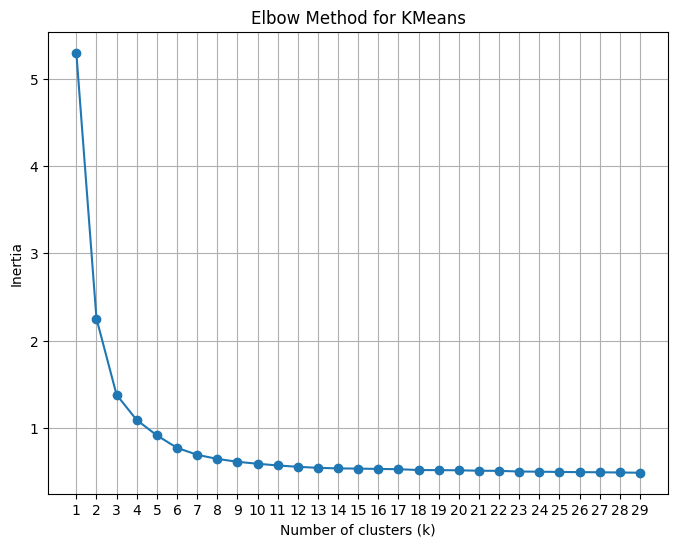

Cluster mapping: {np.int64(0): np.int32(11), np.int64(1): np.int32(20), np.int64(2): np.int32(16), np.int64(3): np.int32(25), np.int64(4): np.int32(11), np.int64(5): np.int32(17), np.int64(6): np.int32(26), np.int64(7): np.int32(4), np.int64(8): np.int32(24), np.int64(9): np.int32(26), np.int64(10): np.int32(16), np.int64(11): np.int32(13), np.int64(12): np.int32(2), np.int64(13): np.int32(13), np.int64(14): np.int32(25), np.int64(15): np.int32(20), np.int64(16): np.int32(9), np.int64(17): np.int32(2), np.int64(18): np.int32(29), np.int64(19): np.int32(16), np.int64(20): np.int32(28), np.int64(21): np.int32(25), np.int64(22): np.int32(2), np.int64(23): np.int32(28), np.int64(24): np.int32(5), np.int64(25): np.int32(3), np.int64(26): np.int32(0), np.int64(27): np.int32(25), np.int64(28): np.int32(11), np.int64(29): np.int32(4), np.int64(30): np.int32(2), np.int64(31): np.int32(13), np.int64(32): np.int32(0), np.int64(33): np.int32(4), np.int64(34): np.int32(13), np.int64(35): np.int32(8

In [48]:
def preprocess_embeddings(embeddings):
    """
    Convert input embeddings to a 2D numpy array.
    """
    if isinstance(embeddings, list):
        embeddings = np.vstack(embeddings)
    return embeddings

def compute_elbow(embeddings, k_range=range(1, 11)):
    """
    Compute inertia values for a range of k values using KMeans.

    """
    embeddings = preprocess_embeddings(embeddings)
    inertias = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(embeddings)
        inertias.append(kmeans.inertia_)
    return inertias

def plot_elbow(embeddings, k_range=range(1, 11), title="Elbow Method for KMeans"):
    """
    Plot the elbow curve using the computed inertia values.

    """
    inertias = compute_elbow(embeddings, k_range=k_range)
    plt.figure(figsize=(8, 6))
    plt.plot(list(k_range), inertias, marker='o')
    plt.title(title)
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia")
    plt.xticks(list(k_range))
    plt.grid(True)
    plt.show()

def cluster_for_k(embeddings, k, ids=None, random_state=42):
    """
    Cluster the provided embeddings using KMeans for a specified number of clusters (k)
    and return a dictionary mapping sample IDs to cluster labels.
    """
    embeddings = preprocess_embeddings(embeddings)
    if ids is None:
        ids = np.arange(embeddings.shape[0])
    
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    cluster_labels = kmeans.fit_predict(embeddings)
    
    id_to_cluster = {sample_id: label for sample_id, label in zip(ids, cluster_labels)}
    return id_to_cluster, kmeans


    
# Use the elbow method to help choose k
plot_elbow(samples, k_range=range(1, 30))

# Cluster for a chosen k (e.g., k = 30) and print cluster mapping.
id_to_cluster, kmeans_model = cluster_for_k(samples, k=30)

In [50]:
Cluster_ids, km = cluster_for_k(samples, 6)

In [78]:
import random
target_total = 500

# --- 1. Group embeddings by cluster ---
clusters = {}
for idx, cluster_id in id_to_cluster.items():
    clusters.setdefault(cluster_id, []).append(samples[idx])

total_embeddings = len(samples)

# --- 2. Compute proportional allocation for each cluster ---
cluster_counts = {cluster_id: len(emb_list) for cluster_id, emb_list in clusters.items()}
cluster_sample_distribution = {}
for cluster_id, count in cluster_counts.items():
    allocated = (count / total_embeddings) * target_total
    cluster_sample_distribution[cluster_id] = allocated

# Use largest remainder method to convert allocations to integers summing to 500
floor_allocations = {cid: math.floor(val) for cid, val in cluster_sample_distribution.items()}
remainders = {cid: cluster_sample_distribution[cid] - floor_allocations[cid] for cid in cluster_sample_distribution}
sum_floor = sum(floor_allocations.values())
remaining = target_total - sum_floor

# Assign extra samples to clusters with highest remainders
sorted_clusters = sorted(remainders.items(), key=lambda x: x[1], reverse=True)
final_distribution = floor_allocations.copy()
for i in range(remaining):
    cid = sorted_clusters[i][0]
    final_distribution[cid] += 1

print("Distribution of synthetic samples per cluster:", final_distribution)

# --- 3. Generate synthetic data ---
synthetic_samples = []

for cluster_id, num_samples in final_distribution.items():
    emb_list = clusters[cluster_id]  # List of embeddings in this cluster
    for _ in range(num_samples):
        # Randomly pick 4 embeddings from emb_list
        if len(emb_list) < 4:
            chosen = random.choices(emb_list, k=4)  # Sample with replacement if needed
        else:
            chosen = random.sample(emb_list, 4)       # Sample without replacement normally
        avg_emb = np.mean(chosen, axis=0)  # Average the 4 embeddings; shape: (2190,)
        print("avg_emb", avg_emb.shape)
        
        # Convert the averaged embedding to a torch tensor and add batch dimension
        condition_tensor = torch.tensor(avg_emb, dtype=torch.float32, device=device).unsqueeze(0)
        # Adjust the condition tensor to the expected dimension (gen.cond_dim)
        expected_dim = gen.cond_dim    # Expected condition dimension (e.g. 1000)
        current_dim = condition_tensor.shape[1]
        if current_dim != expected_dim:
            if current_dim > expected_dim:
                condition_tensor = condition_tensor[:, :expected_dim]
            else:
                pad = torch.zeros((1, expected_dim - current_dim), device=device)
                condition_tensor = torch.cat([condition_tensor, pad], dim=1)
        print("condition_tensor", condition_tensor.shape)
        
        # Generate a random noise vector for the generator using the correct latent dimension
        noise = torch.randn(1, gen.latent_dim, device=device)
        print("noise", noise.shape)
        
        # Generate synthetic sample using the generator.
        # Adjust indexing based on your generator output if necessary.
        with torch.no_grad():
            gen_output = gen(noise, condition_tensor)
        # For example: if gen_output has shape (1, 1, 1, seq_len), extract sample as follows.
        syn_sample = gen_output[0, 0, 0, :].cpu().detach().numpy()
        synthetic_samples.append(syn_sample)

print("Number of synthetic samples generated:", len(synthetic_samples))

Distribution of synthetic samples per cluster: {np.int32(11): 11, np.int32(20): 17, np.int32(16): 25, np.int32(25): 31, np.int32(17): 25, np.int32(26): 15, np.int32(4): 19, np.int32(24): 22, np.int32(13): 35, np.int32(2): 27, np.int32(9): 5, np.int32(29): 13, np.int32(28): 19, np.int32(5): 13, np.int32(3): 27, np.int32(0): 16, np.int32(8): 6, np.int32(6): 16, np.int32(23): 8, np.int32(19): 22, np.int32(18): 19, np.int32(10): 18, np.int32(12): 15, np.int32(1): 16, np.int32(27): 4, np.int32(15): 17, np.int32(21): 12, np.int32(14): 17, np.int32(22): 2, np.int32(7): 8}
avg_emb (2190,)
condition_tensor torch.Size([1, 1000])
noise torch.Size([1, 1000])
avg_emb (2190,)
condition_tensor torch.Size([1, 1000])
noise torch.Size([1, 1000])
avg_emb (2190,)
condition_tensor torch.Size([1, 1000])
noise torch.Size([1, 1000])
avg_emb (2190,)
condition_tensor torch.Size([1, 1000])
noise torch.Size([1, 1000])
avg_emb (2190,)
condition_tensor torch.Size([1, 1000])
noise torch.Size([1, 1000])
avg_emb (2190

In [80]:
# Convert list to numpy array and transpose so that shape becomes (2190, 500)
generated_array = np.array(samples).T  # Now shape is (2190, 500)

# Create DataFrame with the same index as df_downsampled and column names "0", "1", ..., "499"
df_generated = pd.DataFrame(generated_array,
                            index=df_downsampled.index,
                            columns=[str(i) for i in range(500)])

# Now, df_generated has shape (2190, 500)
print(df_generated.shape)

(2190, 500)


In [81]:
def repeat_rows(df, factor=4):
    # Repeat the index values and use .loc to get the repeated rows.
    repeated_df = df.loc[df.index.repeat(factor)].copy()
    repeated_df
    
    return repeated_df

In [19]:
# CHECK IF WE CAN USE FULL SAMPLE IN create_plots

#df_first500 = df_downsampled.iloc[:, :500]

In [82]:
# Restore the row structure by repeating each row 4 times
df_generated_restored = repeat_rows(df_generated, factor=4)
df_first500_restored = repeat_rows(df_downsampled, factor=4)

# Now replace the index with the original timestamp index
df_generated_restored.index = df.index
df_first500_restored.index = df.index

In [83]:
fig_dict, rmse_dict = create_plots(df_generated_restored, df_first500_restored)

In [84]:
score = 0
for item in rmse_dict.values():
    score += item.loc[item['statistic'] != 'median', 'value'].sum()

print(score)

12.496802496195283


In [85]:
import matplotlib.pyplot as plt

def plot_time_series(df, columns):

  plt.figure(figsize=(200, 6))
  for col in columns:
    if col in df.columns:
        plt.plot(df.index, df[col], label=col)
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")
  plt.xlabel("Time")
  plt.ylabel("Values")
  plt.title("Time Series Plot")
  plt.legend()
  plt.grid(True)
  plt.show()


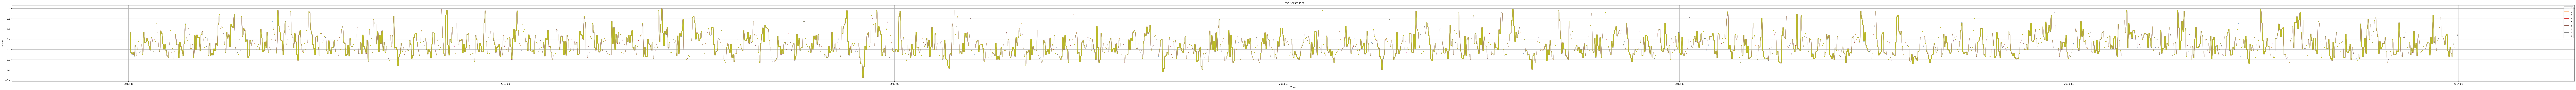

In [87]:
col_names = [str(i) for i in range(1,10)]
plot_time_series(df_generated_restored,col_names)